# <div style="color: DarkCyan">Case Study V: Web Scraping</div>
**Business case:** We want to curate famous quotes and be able to label them automatically.

**Data source:** <a href="http://quotes.toscrape.com/" target="_blank">Quotes to scrape</a>

## Scrape a single page
*We need the locations of the quotes.*

In [1]:
%run ./utils

In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
page = requests.get('http://quotes.toscrape.com')

soup = BeautifulSoup(page.content, 'html.parser')

In [4]:
quote_divs = soup.find_all(class_='quote')

In [5]:
single_quote_div = quote_divs[0]

In [6]:
single_quote_div.find(class_='text').text

'“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”'

In [7]:
single_quote_div.find(class_='author').text

'Albert Einstein'

In [8]:
[tag.text for tag in single_quote_div.find_all(class_='tag')]

['change', 'deep-thoughts', 'thinking', 'world']

## Wrap to a function

In [9]:
import pandas as pd

def scrape_quote(quote):
    text = quote.find(class_='text').text
    author = quote.find(class_='author').text
    tags = [tag.text for tag in quote.find_all(class_='tag')]
    return [text, author, tags]

def scrape_single_results_page(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    return pd.DataFrame(
        list(map(scrape_quote, soup.find_all(class_='quote'))),
        columns=['quote', 'author', 'tags'])

In [10]:
scrape_single_results_page('http://quotes.toscrape.com')

,quote,author,tags
0,“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”,Albert Einstein,"[change, deep-thoughts, thinking, world]"
1,"“It is our choices, Harry, that show what we truly are, far more than our abilities.”",J.K. Rowling,"[abilities, choices]"
2,“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”,Albert Einstein,"[inspirational, life, live, miracle, miracles]"
3,"“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”",Jane Austen,"[aliteracy, books, classic, humor]"
4,"“Imperfection is beauty, madness is genius and it's better to be absolutely ridiculous than absolutely boring.”",Marilyn Monroe,"[be-yourself, inspirational]"
5,“Try not to become a man of success. Rather become a man of value.”,Albert Einstein,"[adulthood, success, value]"
6,“It is better to be hated for what you are than to be loved for what you are not.”,André Gide,"[life, love]"
7,"“I have not failed. I've just found 10,000 ways that won't work.”",Thomas A. Edison,"[edison, failure, inspirational, paraphrased]"
8,“A woman is like a tea bag; you never know how strong it is until it's in hot water.”,Eleanor Roosevelt,[misattributed-eleanor-roosevelt]
9,"“A day without sunshine is like, you know, night.”",Steve Martin,"[humor, obvious, simile]"


# Scrape all pages

In [11]:
pages = ['http://quotes.toscrape.com'] + ['http://quotes.toscrape.com/page/{}/'.format(str(page_number))
    for page_number in list(range(2, 11))]

In [12]:
famous_quotes = pd.concat(list(map(scrape_single_results_page, pages)), ignore_index=True)

# Quick look at data

In [13]:
famous_quotes.shape

(100, 3)

In [14]:
famous_quotes.head()

,quote,author,tags
0,“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”,Albert Einstein,"[change, deep-thoughts, thinking, world]"
1,"“It is our choices, Harry, that show what we truly are, far more than our abilities.”",J.K. Rowling,"[abilities, choices]"
2,“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”,Albert Einstein,"[inspirational, life, live, miracle, miracles]"
3,"“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”",Jane Austen,"[aliteracy, books, classic, humor]"
4,"“Imperfection is beauty, madness is genius and it's better to be absolutely ridiculous than absolutely boring.”",Marilyn Monroe,"[be-yourself, inspirational]"


In [15]:
tags = pd.DataFrame(famous_quotes.tags.agg('sum'), columns=['tag']).reset_index()

In [16]:
tags.groupby('tag').count().sort_values('index', ascending=False).head()

,index
tag,
love,14
life,13
inspirational,13
humor,12
books,11


# Predict love...

In [17]:
data_love = pd.concat([
    famous_quotes, 
    (famous_quotes
         .tags
         .str.join(' ')
         .str.contains('love')
         .astype(int)
         .rename('love'))], axis=1)

In [18]:
data_love.quote.str.len().mean()

122.27

In [19]:
data_love.head()

,quote,author,tags,love
0,“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”,Albert Einstein,"[change, deep-thoughts, thinking, world]",0
1,"“It is our choices, Harry, that show what we truly are, far more than our abilities.”",J.K. Rowling,"[abilities, choices]",0
2,“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”,Albert Einstein,"[inspirational, life, live, miracle, miracles]",0
3,"“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”",Jane Austen,"[aliteracy, books, classic, humor]",0
4,"“Imperfection is beauty, madness is genius and it's better to be absolutely ridiculous than absolutely boring.”",Marilyn Monroe,"[be-yourself, inspirational]",0


In [20]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english').fit(data_love.quote)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 8.11 ms


In [21]:
data_features = tfidf.transform(data_love.quote)

In [22]:
from imblearn.over_sampling import RandomOverSampler


Selecting regularization parameter...
Using hyperparameter=5
Evaluating model on 2 folds...



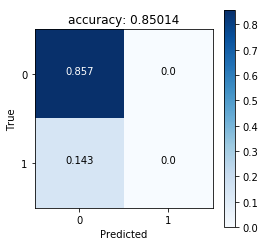

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
simple_classification_performance(
    data_features, 
    data_love.love, 
    model_name='random_forest',
    n_folds=2,
    oversampler=RandomOverSampler(random_state=42),
    grid={'max_depth': [5]},
    run_grid_search=False)

## Word embeddings
Several pretrained models available online. An example is the family of <a target='_blank' href='https://nlp.stanford.edu/projects/glove/'>Glove embeddings</a>.

In [24]:
from gensim.models.keyedvectors import KeyedVectors

word_embedding = KeyedVectors.load_word2vec_format('https://s3-us-west-2.amazonaws.com/big-data-expert-ii-data/famous-quotes/w2v.glove.6B.50.txt')

In [25]:
word_embedding.most_similar(positive=['queen', 'man'], negative=['woman'])

[('king', 0.861202597618103),
 ('prince', 0.8110411763191223),
 ('crown', 0.7789079546928406),
 ('royal', 0.7496289014816284),
 ('knight', 0.7449893951416016),
 ('coronation', 0.7430911660194397),
 ('lady', 0.7329778075218201),
 ('lord', 0.7321771383285522),
 ('great', 0.7172718048095703),
 ('name', 0.7124993801116943)]

In [26]:
data_words = famous_quotes.quote.str.replace('[^a-zA-Z0-9\s]', '').str.lower().str.split()

In [27]:
word_embedding.most_similar('love')

[('dream', 0.8429608941078186),
 ('life', 0.8403438925743103),
 ('dreams', 0.8398563861846924),
 ('loves', 0.8361135721206665),
 ('me', 0.8351818323135376),
 ('my', 0.822745144367218),
 ('mind', 0.8217629790306091),
 ('loving', 0.8107606768608093),
 ('wonder', 0.8073381185531616),
 ('soul', 0.801491379737854)]

In [28]:
stopwords = ['a', 'about', 'above', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also','although','always','am','among', 'amongst', 'amoungst', 'amount',  'an', 'and', 'another', 'any','anyhow','anyone','anything','anyway', 'anywhere', 'are', 'around', 'as',  'at', 'back','be','became', 'because','become','becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom','but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven','else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fify', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'ie', 'if', 'in', 'inc', 'indeed', 'interest', 'into', 'is', 'it', 'its', 'itself', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made', 'many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'never', 'nevertheless', 'next', 'nine', 'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own','part', 'per', 'perhaps', 'please', 'put', 'rather', 're', 'same', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 'should', 'show', 'side', 'since', 'sincere', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'system', 'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'thickv', 'thin', 'third', 'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'until', 'up', 'upon', 'us', 'very', 'via', 'was', 'we', 'well', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', 'the']


Selecting regularization parameter...
Using hyperparameter=20
Evaluating model on 2 folds...



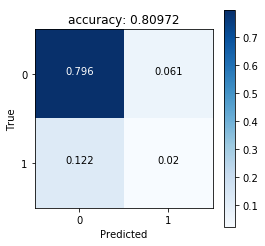

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
love_words = set([
    'love', 
    'despair',
    'cheat',
    'hate', 
    'envy', 
    'jealous', 
    'good',
    'sad',
    'happy',
    'intimate', 
    'sex' 
])

def love_per_word(words):
    words_in_vocabulary = [w for w in words if w in word_embedding.vocab]
        
    return np.array(
        [[word_embedding.distance(love_word, w) for love_word in love_words]
         for w in words_in_vocabulary]).mean(axis=0)

data_vectors = np.array(data_words.apply(love_per_word).tolist())

simple_classification_performance(
    data_vectors, 
    data_love.love, 
    oversampler=RandomOverSampler(random_state=42),
    n_folds=2,
    n_estimators=200,
    model_name='random_forest',
    grid={'max_depth': [20]},
    run_grid_search=False)